In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/552_crop6.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/267_crop16.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/50_crop12.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/405_crop11.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/598_crop9.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/435_crop2.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/435_crop14.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/373_crop8.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/175_crop13.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/107_crop6.png
/kaggle/input/cropped-final-kymograms/final kymograms cropped/functional/72_crop15.png
/kaggle/input/cropped-final-kymograms/f

In [3]:
import os
import shutil
import random
import time
import copy
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

!pip install -q timm
import timm


In [2]:
!pip install -q efficientnet_pytorch

In [4]:
# Paths
src_dir = Path("/kaggle/input/cropped-final-kymograms/final kymograms cropped")
dst_dir = Path("/kaggle/working/tertiary_split")

# Step 1: Gather all images with labels
all_images = [(img, cls) for cls in os.listdir(src_dir) for img in (src_dir / cls).glob("*.png")]

# Step 2: Global split (15% test)
trainval, test = train_test_split(
    all_images, test_size=0.15, random_state=42, stratify=[label for _, label in all_images]
)
# Step 3: Train (70%) / Val (15%)
train, val = train_test_split(
    trainval, test_size=0.15, random_state=42, stratify=[label for _, label in trainval]
)

# Step 4: Copy images
def copy_images(split_name, data):
    for img_path, cls in data:
        split_dir = dst_dir / split_name / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, split_dir / img_path.name)

copy_images("train", train)
copy_images("val", val)
copy_images("test", test)

# Step 5: Oversample training set
train_dir = dst_dir / "train"
class_counts = {cls.name: len(list(cls.glob("*.png"))) for cls in train_dir.iterdir()}
max_count = max(class_counts.values())

for cls_name, count in class_counts.items():
    cls_path = train_dir / cls_name
    images = list(cls_path.glob("*.png"))
    if count < max_count:
        needed = max_count - count
        to_duplicate = random.choices(images, k=needed)
        for i, img in enumerate(to_duplicate):
            new_name = cls_path / f"{img.stem}_dup{i}{img.suffix}"
            shutil.copy(img, new_name)

print("✅ Training set balanced by oversampling.")


✅ Training set balanced by oversampling.


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

data_dirs = {
    'train': dst_dir / 'train',
    'val': dst_dir / 'val',
    'test': dst_dir / 'test',
}

train_data = datasets.ImageFolder(data_dirs['train'], transform=data_transforms['train'])
val_data = datasets.ImageFolder(data_dirs['val'], transform=data_transforms['val'])
test_data = datasets.ImageFolder(data_dirs['test'], transform=data_transforms['test'])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [6]:
# Model
eff_net = timm.create_model('efficientnetv2_s', pretrained=False, num_classes=3)
class EMA:
    def __init__(self, model, beta=0.999):
        self.beta = beta
        self.ema_params = {name: param.clone().detach() for name, param in model.named_parameters()}
        self.ema_buffers = {name: buffer.clone().detach() for name, buffer in model.named_buffers()}

    def update(self, model, step):
        with torch.no_grad():
            decay = self.beta ** (step + 1)

            # Update EMA parameters
            for name, param in model.named_parameters():
                if name in self.ema_params:
                    self.ema_params[name].mul_(decay).add_(param.data * (1. - decay))

            # Update EMA buffers (e.g., running stats in batch norm)
            for name, buffer in model.named_buffers():
                if name in self.ema_buffers:
                    # Convert to float for safe computation, then restore dtype
                    new_buf = self.ema_buffers[name].float().mul(decay).add(buffer.data.float() * (1. - decay))
                    self.ema_buffers[name] = new_buf.to(buffer.dtype)

    def apply_ema(self):
        # Load EMA values into model
        for name, param in model.named_parameters():
            param.data.copy_(self.ema_params[name])
        for name, buffer in model.named_buffers():
            buffer.data.copy_(self.ema_buffers[name])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eff_net.to(device)
optimizer = optim.Adam(eff_net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
ema = EMA(eff_net)

num_epochs = 30
best_val_acc = 0.0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_model_wts = copy.deepcopy(eff_net.state_dict())

for epoch in range(num_epochs):
    eff_net.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = eff_net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ema.update(eff_net, step)

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    eff_net.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = eff_net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(eff_net.state_dict())
        torch.save(eff_net.state_dict(), "best_model_effnetv2.pth")

    print(f"Epoch {epoch+1}/{num_epochs} - {int(time.time()-start_time)}s - "
          f"acc: {train_acc:.4f} - loss: {train_loss:.4f} - "
          f"val_acc: {val_acc:.4f} - val_loss: {val_loss:.4f}")


Epoch 1/30 - 182s - acc: 0.4790 - loss: 1.2143 - val_acc: 0.4945 - val_loss: 1.3399
Epoch 2/30 - 188s - acc: 0.6312 - loss: 0.8482 - val_acc: 0.5935 - val_loss: 1.5024
Epoch 3/30 - 188s - acc: 0.7764 - loss: 0.5543 - val_acc: 0.7528 - val_loss: 0.6324
Epoch 4/30 - 189s - acc: 0.8702 - loss: 0.3398 - val_acc: 0.8391 - val_loss: 0.4552
Epoch 5/30 - 190s - acc: 0.9287 - loss: 0.1985 - val_acc: 0.9200 - val_loss: 0.2339
Epoch 6/30 - 190s - acc: 0.9551 - loss: 0.1277 - val_acc: 0.9493 - val_loss: 0.1834
Epoch 7/30 - 188s - acc: 0.9606 - loss: 0.1115 - val_acc: 0.9319 - val_loss: 0.2169
Epoch 8/30 - 189s - acc: 0.9711 - loss: 0.0845 - val_acc: 0.9572 - val_loss: 0.2489
Epoch 9/30 - 189s - acc: 0.9677 - loss: 0.0895 - val_acc: 0.9778 - val_loss: 0.0995
Epoch 10/30 - 188s - acc: 0.9789 - loss: 0.0633 - val_acc: 0.9612 - val_loss: 0.1521
Epoch 11/30 - 189s - acc: 0.9806 - loss: 0.0607 - val_acc: 0.9635 - val_loss: 0.1724
Epoch 12/30 - 188s - acc: 0.9815 - loss: 0.0521 - val_acc: 0.9667 - val_lo

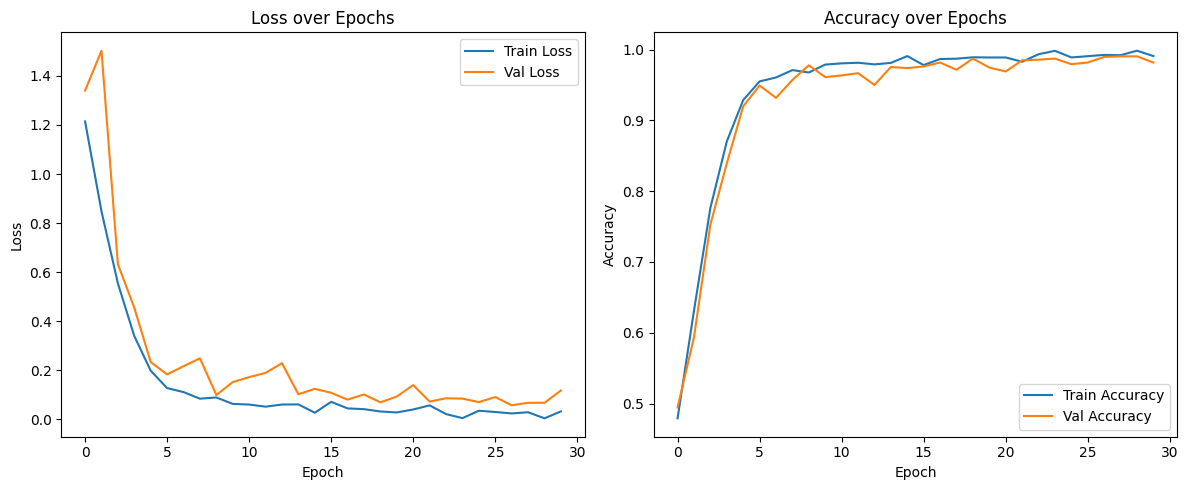

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
class_names = ['functional', 'healthy','organic']  # Update this list as per your dataset
n_classes = len(class_names)



Validation Report on Model:
Metrics             Value
----------------------------------------
functional
AUC (%)                99.98
F1 Score (%)           98.71
Precision (%)          97.80
Recall (%)             99.63
Sensitivity (%)        99.63
Specificity (%)        99.40
----------------------------------------
healthy
AUC (%)                99.77
F1 Score (%)           99.31
Precision (%)          99.49
Recall (%)             99.12
Sensitivity (%)        99.12
Specificity (%)        99.15
----------------------------------------
organic
AUC (%)                99.79
F1 Score (%)           98.50
Precision (%)          98.99
Recall (%)             98.01
Sensitivity (%)        98.01
Specificity (%)        99.81
----------------------------------------
Overall Accuracy (%)   99.05


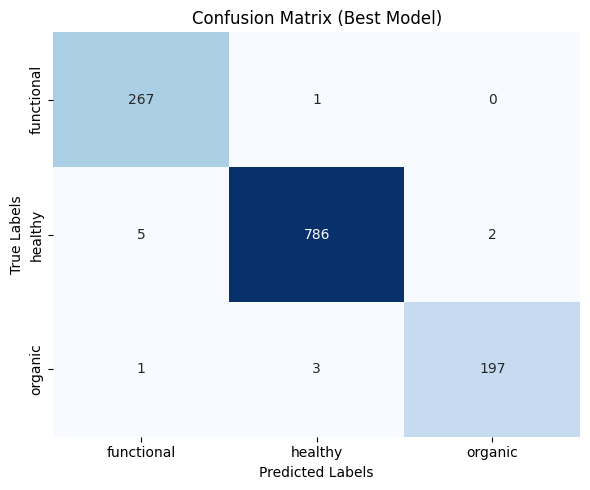

In [11]:
import seaborn as sns
# Load best model weights
eff_net.load_state_dict(best_model_wts)
eff_net.eval()

val_y_true = []
val_y_pred = []
val_y_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = eff_net(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        val_y_true.extend(labels.cpu().numpy())
        val_y_pred.extend(preds.cpu().numpy())
        val_y_probs.extend(probs.cpu().numpy())

val_y_true = np.array(val_y_true)
val_y_pred = np.array(val_y_pred)
val_y_probs = np.array(val_y_probs)

val_y_true_bin = label_binarize(val_y_true, classes=list(range(n_classes)))
val_auc_per_class = roc_auc_score(val_y_true_bin, val_y_probs, average=None) * 100
val_auc_macro = roc_auc_score(val_y_true_bin, val_y_probs, average='macro') * 100
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)
val_conf_matrix = confusion_matrix(val_y_true, val_y_pred)

val_sensitivity = []
val_specificity = []

for i in range(n_classes):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    val_sensitivity.append(sensitivity)
    val_specificity.append(specificity)

print("\nValidation Report on Model:")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<20}{val_auc_per_class[i]:>8.2f}")
    print(f"{'F1 Score (%)':<20}{val_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{val_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{val_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{val_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{val_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{best_val_acc * 100:>8.2f}")


# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



Test Report:
Metrics             Value
----------------------------------------
functional
AUC (%)                99.97
F1 Score (%)           98.59
Precision (%)          97.82
Recall (%)             99.37
Sensitivity (%)        99.37
Specificity (%)        99.40
----------------------------------------
healthy
AUC (%)                99.92
F1 Score (%)           99.25
Precision (%)          99.36
Recall (%)             99.14
Sensitivity (%)        99.14
Specificity (%)        98.91
----------------------------------------
organic
AUC (%)                99.94
F1 Score (%)           98.93
Precision (%)          99.57
Recall (%)             98.31
Sensitivity (%)        98.31
Specificity (%)        99.92
----------------------------------------
Overall Accuracy (%)   99.06


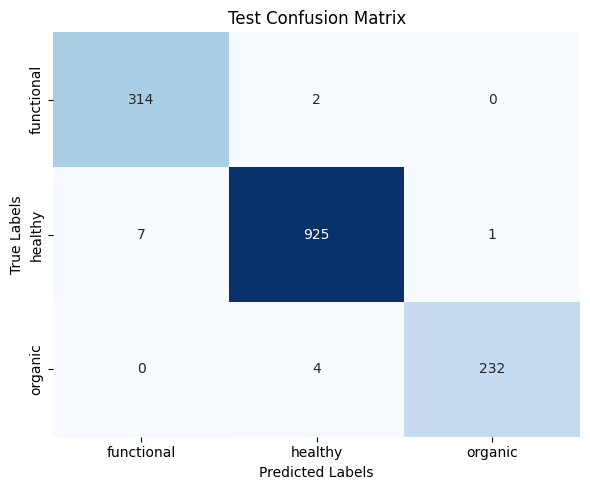

In [12]:
# Testing Report using the Best Model
eff_net.eval()

test_y_true = []
test_y_pred = []
test_y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = eff_net(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_y_true.extend(labels.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs.cpu().numpy())

test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred)
test_y_probs = np.array(test_y_probs)

test_y_true_bin = label_binarize(test_y_true, classes=list(range(n_classes)))
test_auc_per_class = roc_auc_score(test_y_true_bin, test_y_probs, average=None) * 100
test_auc_macro = roc_auc_score(test_y_true_bin, test_y_probs, average='macro') * 100
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)
test_conf_matrix = confusion_matrix(test_y_true, test_y_pred)

test_sensitivity = []
test_specificity = []

for i in range(n_classes):
    TP = test_conf_matrix[i, i]
    FN = test_conf_matrix[i].sum() - TP
    FP = test_conf_matrix[:, i].sum() - TP
    TN = test_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    test_sensitivity.append(sensitivity)
    test_specificity.append(specificity)

print("\nTest Report:")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<20}{test_auc_per_class[i]:>8.2f}")
    print(f"{'F1 Score (%)':<20}{test_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{test_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{test_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{test_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{test_specificity[i]:>8.2f}")
    print("-" * 40)

test_acc = accuracy_score(test_y_true, test_y_pred)
print(f"{'Overall Accuracy (%)':<20}{test_acc * 100:>8.2f}")


plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# If history is a dictionary, we can directly convert it to a DataFrame
history_df = pd.DataFrame(history)
history_df.to_csv("accuracy_loss_pereffnet_tertiary_epoch.csv", index=False)




# Binarize labels for ROC curve (One-hot encode true labels)
n_classes = 3
y_true_bin = label_binarize(test_y_true, classes=[0, 1, 2])
y_pred_probs = test_y_probs

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # y_pred_probs should be a numpy array
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Save ROC values to CSV
roc_data = []

class_names = ["Class 0", "Class 1", "Class 2"]  # Replace with your actual class names if different

for i in range(n_classes):
    for fp, tp in zip(fpr[i], tpr[i]):
        roc_data.append({"class": class_names[i], "fpr": fp, "tpr": tp, "auc": roc_auc[i]})

# Micro average
for fp, tp in zip(fpr["micro"], tpr["micro"]):
    roc_data.append({"class": "micro", "fpr": fp, "tpr": tp, "auc": roc_auc["micro"]})

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_values_effnet_tertiary.csv", index=False)


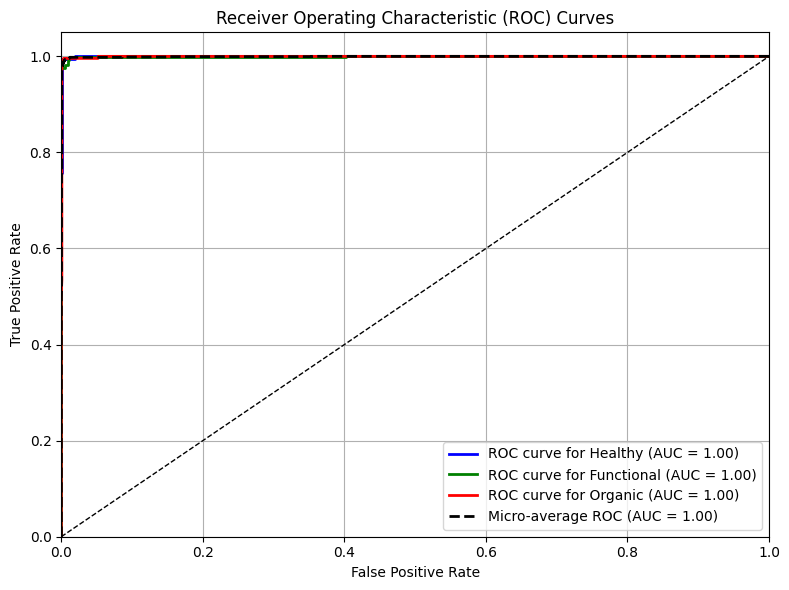

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Class names
class_names = ["Healthy", "Functional", "Organic"]  # Update if different
n_classes = len(class_names)

# Binarize the true labels
y_true_bin = label_binarize(test_y_true, classes=[0, 1, 2])
y_score = np.array(test_y_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

# Plot per-class ROC
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
